## Train a ConvNet to recognize objects using the CIFAR dataset

In this tutorial, we train a ConvNet from scratch to do object recognition over 10 classes.
You would learn how to use Torch's neural network package and optim package to train a network.

In [1]:
-- require the necessary packages
require 'torch'
require 'nn'
require 'optim'
require 'image'
require 'xlua'


torch.setdefaulttensortype('torch.FloatTensor')

In [2]:
-- manually define the class-names in CIFAR-10 in a lua table
classes={'bridge', 'building', 'city', 'eiffel_tower','elephant', 'landscape', 'lion', 'monkey', 'people', 'tower', 'water'}


In [3]:
-- define model to train
model = nn.Sequential()
--[[ stage 1 : mean+std normalization -> filter bank -> squashing -> max pooling
model:add(nn.SpatialConvolutionMM(3,32,5,5))
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))
-- stage 2 : filter bank -> squashing -> max pooling
model:add(nn.SpatialConvolutionMM(32,32,5,5))
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))
]]
-- stage 3 : standard 2-layer neural network
model:add(nn.View(3*64*64))
model:add(nn.Linear(3*64*64, #classes))
--model:add(nn.ReLU())
--model:add(nn.Linear(128,#classes))
model:add(nn.LogSoftMax())


In [4]:
print(model:__tostring())

nn.Sequential {
  [input -> (1) -> (2) -> (3) -> output]
  (1): nn.View(12288)
  (2): nn.Linear(12288 -> 11)
  (3): nn.LogSoftMax
}	


In [5]:
-- retrieve parameters and gradients. this helps us to use the optim package
parameters,gradParameters = model:getParameters()

In [6]:
-- loss function: negative log-likelihood
criterion = nn.ClassNLLCriterion()
print (criterion)

nn.ClassNLLCriterion
{
  sizeAverage : true
  output : 0
  gradInput : FloatTensor - empty
  output_tensor : FloatTensor - size: 1
  target : LongTensor - size: 1
  total_weight_tensor : FloatTensor - size: 1
}


In [7]:
batchSize = 64 -- sets the mini-Batch size



182	


157	


85	


17	


223	


44	


288	


215	


164	


153	


190	


In [ ]:
dofile('loadData.ipy')

In [9]:
--trainData.labels = trainData.labels + 1
trainData.data = trainData.data:reshape(1673,3,64,64)

In [10]:

temp=0
for i=1,1672 do 
    if trainData.labels[i] == 0 then
        temp= temp+1
        print(i)
    end
end
print (temp)


0	


In [11]:
-- preprocess/normalize train/test sets
-- preprocess trainSet
collectgarbage()



normalization = nn.SpatialContrastiveNormalization(1, image.gaussian1D(7))

for i = 1,1673 do
   -- rgb -> yuv
   local rgb = trainData.data[i]
   local yuv = image.rgb2yuv(rgb)
   -- normalize y locally:
   yuv[1] = normalization(yuv[{{1}}])
   trainData.data[i] = yuv
end
-- normalize u globally:
mean_u = trainData.data[{ {},2,{},{} }]:mean()
std_u = trainData.data[{ {},2,{},{} }]:std()
trainData.data[{ {},2,{},{} }]:add(-mean_u)
trainData.data[{ {},2,{},{} }]:div(-std_u)
-- normalize v globally:
mean_v = trainData.data[{ {},3,{},{} }]:mean()
std_v = trainData.data[{ {},3,{},{} }]:std()
trainData.data[{ {},3,{},{} }]:add(-mean_v)
trainData.data[{ {},3,{},{} }]:div(-std_v)


In [12]:
collectgarbage()
--trainData.data:mul(10000)

In [13]:
-- this matrix records the current confusion across classes
confusion = optim.ConfusionMatrix(classes)

In [14]:
-- define training and testing functions

In [15]:
-- training function
function train(dataset)
   -- epoch tracker
   epoch = epoch or 1

   -- do one epoch
   print('<trainer> on training set:')
   print("<trainer> online epoch # " .. epoch .. ' [batchSize = ' .. batchSize .. ']')
   for t = 1,dataset:size(),batchSize do

      -- create mini batch
      local inputs = {}
      local targets = {}
      for i = t,math.min(t+batchSize-1,dataset:size()) do
         -- load new sample
         local input = dataset.data[i]
         local target = dataset.labels[i]
         table.insert(inputs, input)
         table.insert(targets, target)
      end
      -- create closure to evaluate f(X) and df/dX
      local feval = function(x)
                       -- get new parameters
                       if x ~= parameters then
                          parameters:copy(x)
                       end

                       -- reset gradients
                       gradParameters:zero()

                       -- f is the average of all criterions
                       local f = 0

                       -- evaluate function for complete mini batch
                       for i = 1,#inputs do
                          -- estimate f
                          local output = model:forward(inputs[i])
                          local err = criterion:forward(output, targets[i])
                          f = f + err

                          -- estimate df/dW
                          local df_do = criterion:backward(output, targets[i])
                          model:backward(inputs[i], df_do)

                          -- update confusion
                          confusion:add(output, targets[i])                        
                       end

                       -- normalize gradients and f(X)
                       gradParameters:div(#inputs)
                       f = f/#inputs

                       -- return f and df/dX
                       return f,gradParameters
                    end


      config = config or {learningRate = 1e-3,
              weightDecay = 0,
                momentum = 0,
              learningRateDecay = 5e-7}
      optim.sgd(feval, parameters, config)
   end

   -- print confusion matrix
   print(confusion)
   confusion:zero()

   -- next epoch
   epoch = epoch + 1
end


In [16]:
-- test function
function test(dataset)

   -- test over given dataset
   print('<trainer> on testing Set:')
   for t = 1,dataset:size() do
      -- get new sample
      local input = dataset.data[t]
      local target = dataset.labels[t]

      -- test sample
      local pred = model:forward(input)
      confusion:add(pred, target)
   end

   -- print confusion matrix
   print(confusion)
   confusion:zero()

end


In [17]:
i=0
while i<10 do
train(trainData)
i=i+1
end

<trainer> on training set:	
<trainer> online epoch # 1 [batchSize = 64]	


ConfusionMatrix:
[[      66      12      19      10       9      17       5       8      11      11      13]   36.464% 	[class: bridge]
 [      61      38       7       4       7       4      10       5       3       5       8]   25.000% 	[class: building]
 [       9      54       9       3       0       2       3       0       0       0       1]   11.111% 	[class: city]
 [       1       8       2       1       2       0       0       1       0       0       1]   6.250% 	[class: eiffel_tower]
 [      12      32      43      13      63      10       5       3       8      14      15]   28.899% 	[class: elephant]
 [       0       0      25       1      12       1       1       1       0       1       2]   2.273% 	[class: landscape]
 [       5       8       4       0      68      14     170       3       3       1       7]   60.071% 	[class: lion]
 [       7      13      11       7      12      18      96      23      12       5       9]   10.798% 	[class: monkey]
 [      14       7      

ConfusionMatrix:
[[      67       5       6       2       3       8       6       9      11      18      46]   37.017% 	[class: bridge]
 [      64      38       4       2       5       4       9       3       2      11      10]   25.000% 	[class: building]
 [       9      48       7       3       0       1       4       3       4       2       0]   8.642% 	[class: city]
 [       3       8       0       0       2       0       0       3       0       0       0]   0.000% 	[class: eiffel_tower]
 [       7      24      31       8      80       9       6      13      11      12      17]   36.697% 	[class: elephant]
 [       2       1      18       0      18       1       2       0       0       1       1]   2.273% 	[class: landscape]
 [       3       6       8       0      66       9     176       6       1       1       7]   62.191% 	[class: lion]
 [       6       8      11       6      11      19      93      33      11       4      11]   15.493% 	[class: monkey]
 [       8       8      1

ConfusionMatrix:
[[      71       4       6       1       2       4      10      10      13      21      39]   39.227% 	[class: bridge]
 [      58      44       3       1       5       5       9       4       2      11      10]   28.947% 	[class: building]
 [      10      45       9       1       0       1       4       3       4       3       1]   11.111% 	[class: city]
 [       4       7       0       0       2       0       0       3       0       0       0]   0.000% 	[class: eiffel_tower]
 [       6      23      29       6      97       7       5      14       9       6      16]   44.495% 	[class: elephant]
 [       2       0      11       0      21       5       2       0       0       2       1]   11.364% 	[class: landscape]
 [       3       6       8       0      59      11     178       7       3       1       7]   62.898% 	[class: lion]
 [       4       7      11       5       8      18      91      46      12       4       7]   21.596% 	[class: monkey]
 [       8       6     

ConfusionMatrix:
[[      74       4       6       1       2       5      11       8      11      23      36]   40.884% 	[class: bridge]
 [      50      53       1       0       5       5       9       5       4      11       9]   34.868% 	[class: building]
 [      10      46       9       1       0       1       4       3       4       3       0]   11.111% 	[class: city]
 [       3       6       0       0       2       1       0       3       1       0       0]   0.000% 	[class: eiffel_tower]
 [       7      21      24       6     102       9       8      19      10       3       9]   46.789% 	[class: elephant]
 [       2       0       9       0      19       9       2       0       0       2       1]   20.455% 	[class: landscape]
 [       2       4       7       0      55       9     183       9       4       1       9]   64.664% 	[class: lion]
 [       3       8       9       3      13      14      87      53      12       5       6]   24.883% 	[class: monkey]
 [       5       6     

ConfusionMatrix:
[[      77       2       6       1       2       5      11       7      13      23      34]   42.541% 	[class: bridge]
 [      48      60       1       0       4       6       9       5       4      10       5]   39.474% 	[class: building]
 [      10      43      13       1       0       1       4       3       3       3       0]   16.049% 	[class: city]
 [       2       5       0       0       2       1       2       2       1       1       0]   0.000% 	[class: eiffel_tower]
 [       6      17      20       6     111      10       8      18      10       3       9]   50.917% 	[class: elephant]
 [       2       0      10       1      15      13       1       0       0       1       1]   29.545% 	[class: landscape]
 [       3       4       5       0      48       9     192      10       4       1       7]   67.845% 	[class: lion]
 [       2       7      11       2      12      10      80      63      15       5       6]   29.577% 	[class: monkey]
 [       5       5     

ConfusionMatrix:
[[      78       3       5       1       3       5      11       6      12      24      33]   43.094% 	[class: bridge]
 [      42      64       1       1       3       6       9       5       6      10       5]   42.105% 	[class: building]
 [      10      42      14       1       1       0       4       3       3       3       0]   17.284% 	[class: city]
 [       2       6       0       1       1       1       2       2       1       0       0]   6.250% 	[class: eiffel_tower]
 [       6      19      15       7     118       8       8      17       8       3       9]   54.128% 	[class: elephant]
 [       2       0      10       1      12      16       1       0       0       1       1]   36.364% 	[class: landscape]
 [       2       5       5       0      47       8     193      11       5       1       6]   68.198% 	[class: lion]
 [       2       8      11       2      11       7      75      71      15       5       6]   33.333% 	[class: monkey]
 [       4       4     

ConfusionMatrix:
[[      80       4       4       1       4       5      11       6      12      24      30]   44.199% 	[class: bridge]
 [      40      66       1       1       4       6       9       6       7       8       4]   43.421% 	[class: building]
 [       8      41      16       1       0       0       5       3       4       3       0]   19.753% 	[class: city]
 [       2       6       0       1       1       1       2       2       1       0       0]   6.250% 	[class: eiffel_tower]
 [       6      19      14       5     126       6       6      16       8       3       9]   57.798% 	[class: elephant]
 [       2       1       8       0      12      18       1       0       0       1       1]   40.909% 	[class: landscape]
 [       2       5       4       0      42       7     199      11       5       2       6]   70.318% 	[class: lion]
 [       2       7      11       2       9       6      71      79      14       5       7]   37.089% 	[class: monkey]
 [       3       4     

    8 : monkey
      9 : people
      10 : tower
      11 : water
    }
  _prediction : FloatTensor - size: 11
  _pred_idx : LongTensor - size: 1
  nclasses : 11
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 11
  totalValid : 0.48595337716677
}
<trainer> on training set:	
<trainer> online epoch # 8 [batchSize = 64]	


ConfusionMatrix:
[[      85       4       2       1       4       4      11       6      10      25      29]   46.961% 	[class: bridge]
 [      39      68       1       1       4       6       9       6       6       6       6]   44.737% 	[class: building]
 [       9      38      20       1       0       1       4       2       2       4       0]   24.691% 	[class: city]
 [       2       5       0       2       1       1       2       2       1       0       0]   12.500% 	[class: eiffel_tower]
 [       5      20      12       4     134       6       6      13       9       2       7]   61.468% 	[class: elephant]
 [       1       2       7       0      10      21       1       0       0       1       1]   47.727% 	[class: landscape]
 [       2       5       4       0      41       4     204      10       5       2       6]   72.085% 	[class: lion]
 [       2       7      10       2       8       6      68      83      13       6       8]   38.967% 	[class: monkey]
 [       3       4    

ConfusionMatrix:
[[      93       4       1       1       4       3      11       5       9      24      26]   51.381% 	[class: bridge]
 [      36      76       1       1       3       6       7       6       5       6       5]   50.000% 	[class: building]
 [      10      35      23       0       0       1       4       2       2       4       0]   28.395% 	[class: city]
 [       2       5       0       2       1       1       2       2       1       0       0]   12.500% 	[class: eiffel_tower]
 [       4      18      12       4     140       4       5      13      10       2       6]   64.220% 	[class: elephant]
 [       0       2       8       0       8      23       1       0       0       1       1]   52.273% 	[class: landscape]
 [       2       4       4       0      38       3     207      10       6       2       7]   73.145% 	[class: lion]
 [       2       8       8       2       7       4      66      90      13       6       7]   42.254% 	[class: monkey]
 [       3       3    

  _pred_idx : LongTensor - size: 1
  nclasses : 11
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 11
  totalValid : 0.54512851165571
}
<trainer> on training set:	
<trainer> online epoch # 10 [batchSize = 64]	


ConfusionMatrix:
[[      97       4       1       0       5       3      10       5       9      22      25]   53.591% 	[class: bridge]
 [      34      79       1       1       3       6       9       6       4       5       4]   51.974% 	[class: building]
 [      10      32      27       0       0       1       4       1       2       4       0]   33.333% 	[class: city]
 [       2       5       0       2       1       1       2       2       1       0       0]   12.500% 	[class: eiffel_tower]
 [       4      16      12       4     144       4       5      12       9       2       6]   66.055% 	[class: elephant]
 [       0       4       6       1       8      23       1       0       0       0       1]   52.273% 	[class: landscape]
 [       2       4       4       0      36       3     211       8       6       1       8]   74.558% 	[class: lion]
 [       1       9       7       2       7       4      65      92      13       6       7]   43.192% 	[class: monkey]
 [       3       3    

{
  valids : FloatTensor - size: 11
  mat : LongTensor - size: 11x11
  averageUnionValid : 0.34241173619574
  _targ_idx : LongTensor - empty
  averageValid : 0.50385031104088
  classes : 
    {
      1 : bridge
      2 : building
      3 : city
      4 : eiffel_tower
      5 : elephant
      6 : landscape
      7 : lion
      8 : monkey
      9 : people
      10 : tower
      11 : water
    }
  _prediction : FloatTensor - size: 11
  _pred_idx : LongTensor - size: 1
  nclasses : 11
  _max : FloatTensor - size: 1
  _target : FloatTensor - empty
  unionvalids : FloatTensor - size: 11
  totalValid : 0.56306037059175
}


In [ ]:
torch.save('model1layer.net',model)

0.15544034851502	


-0.16365542069888	


In [18]:
torch.save('model1.net', model)

In [17]:
timer = torch.Timer()
test(testData)
print (timer:time().real)

<trainer> on testing Set:	


ConfusionMatrix:
[[      24       8       8       5       2       2       8       6      24      16]   23.301% 	[class: airplane]
 [       4      58       1       4       0       0       7       4       1      10]   65.169% 	[class: automobile]
 [       5       5      28      11       8       4      20       7       8       4]   28.000% 	[class: bird]
 [       3       7      11      30       3       6      30       3       5       5]   29.126% 	[class: cat]
 [       4       1      10       8      12       1      37      11       4       2]   13.333% 	[class: deer]
 [       1       5       9      25       4      10      20       4       3       5]   11.628% 	[class: dog]
 [       0       1       3      20       3       5      71       2       3       4]   63.393% 	[class: frog]
 [       5       3       7       8       7       6      13      47       2       4]   46.078% 	[class: horse]
 [      22       9       4       6       2       0       1       4      51       7]   48.113% 	[class:

In [71]:
trainData.labels[1000]

9	


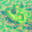

ConfusionMatrix:
[[       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: airplane]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: automobile]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: bird]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: cat]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: deer]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: dog]
 [       0       0       0       0       0       0       1       0       0       0]   100.000% 	[class: frog]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: horse]
 [       0       0       0       0       0       0       0       0       0       0]   nan% 	[class: ship]
 [       0      

In [57]:







j=50
confusion:zero()


itorch.image(testData.data[j])
inp= testData.data[j]
tar= testData.labels[j]

pred = model:forward(inp)
confusion:add(pred, tar)
print(confusion)



In [22]:
print (pred)

-1.1657
-2.3892
-2.5634
-4.5198
-4.0242
-5.7736
-6.7106
-5.2705
-0.9884
-2.2155
[torch.DoubleTensor of dimension 10]



In [41]:
for i=1,100 and i~=5) do
    print(i)
end

[string "for (i=1,100 and i~=5) do..."]:1: '<name>' expected near '(': 

In [38]:
1~=2

true	
